In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from itertools import product 
import scipy.io as sio
import tensorflow as tf
from keras.layers import Lambda
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import KFold

In [ ]:
G1_path = '/content/drive/My Drive/SAR Dataset/goruntu1.mat'
G1label_path = '/content/drive/My Drive/SAR Dataset/goruntu1GT.mat'

G1_mat = sio.loadmat(G1_path)
G1label_mat = sio.loadmat(G1label_path)

G1_raw=G1_mat['goruntu1']
G1label_raw = G1label_mat['goruntu1GT']

np.unique(G1label_raw)
b= np.where(G1label_raw == 7);

G1label_raw[b] = 5
hist, bin_edges = np.histogram(G1label_raw)

b1=np.where(G1label_raw  == 1)
G1label_raw[b1] = 0
b2=np.where(G1label_raw  == 2)
G1label_raw[b2] = 1
b3=np.where(G1label_raw  == 3)
G1label_raw[b3] = 2
b4=np.where(G1label_raw  == 4)
G1label_raw[b4] = 3
b5=np.where(G1label_raw  == 5)
G1label_raw[b5] = 4
b6=np.where(G1label_raw  == 6)
G1label_raw[b6] = 5

#Görüntü1 ve Görüntü1 Ground Truth 500 yamaya ayırma
G1 = np.array([G1_raw[400*i:400*i+400: , 400*j:400*j+400] for i, j in product(range(20), range(25))])
G1label = np.array([G1label_raw[400*i:400*i+400: , 400*j:400*j+400] for i, j in product(range(20), range(25))])

In [ ]:
def max_by_index(idx, arr):
    return np.where(arr[idx] == np.max(arr[idx]))

a = [] 
for i in range(500):

   a.append(max(G1label[i][max_by_index(0, G1label)]))
  
G1label1 = np.asarray(a)


# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(G1label1)

# Display the change for category label using one-hot encoding
print('Original label:', G1label[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
After conversion to one-hot: [1. 0. 0. 0. 0. 0.]


In [ ]:
def max_by_index(idx, arr):
    return np.where(arr[idx] == np.max(arr[idx]))

a = [] 
for i in range(500):

   a.append(max(G1label[i][max_by_index(0, G1label)]))
  
G1label1 = np.asarray(a)
G1label1 = np.append(G1label1,G1label1)
G1label1 = np.append(G1label1,G1label1)


# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(G1label1)

# Display the change for category label using one-hot encoding
print('Original label:', G1label[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
After conversion to one-hot: [1. 0. 0. 0. 0. 0.]


In [ ]:
G1 = G1.reshape(-1, 400,400, 1)
G1.shape

np.max(G1)
G1 = G1 / np.max(G1)
np.max(G1)

1.0

In [ ]:
label_dict = {
 0: 'Deniz',
 1: 'Dalga kıran',
 2: 'Liman',
 3: 'Yüksek yoğunlukta yerleşim alanı',
 4: 'Orta yoğunlukta yerleşim alanı',
 5: 'Marina'
}

In [ ]:
G1_fliped_90= G1.swapaxes(-3,-2)[...,::-1,:]
G1_fliped_180= G1_fliped_90.swapaxes(-3,-2)[...,::-1,:] 
G1_fliped_270= G1.swapaxes(-3,-2)[:,::-1,:,:]

G1_full = G1
G1_full = np.append(G1_full, G1_fliped_90, axis=0)
G1_full = np.append(G1_full, G1_fliped_180, axis=0)
G1_full = np.append(G1_full, G1_fliped_270, axis=0)



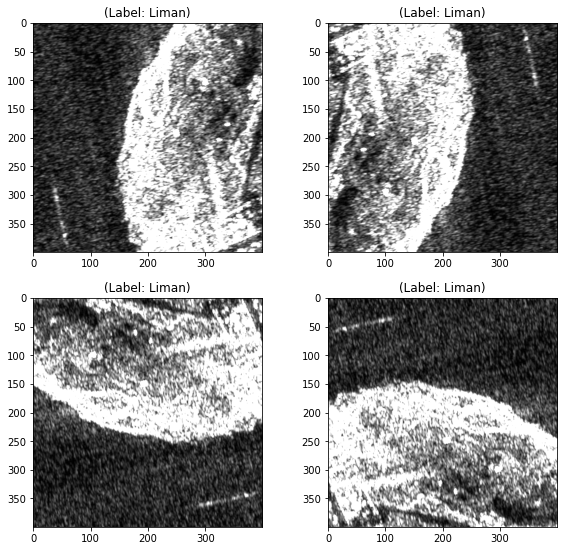

In [ ]:
plt.figure(figsize=[5,5])

plt.subplot(221)
curr_img = np.reshape(G1[481], (400,400))
curr_lbl = G1label1[481]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplot(222)
curr_img = np.reshape(G1_fliped_180[481], (400,400))
curr_lbl = G1label1[481]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplot(223)
curr_img = np.reshape(G1_fliped_270[481], (400,400))
curr_lbl = G1label1[481]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplot(224)
curr_img = np.reshape(G1_fliped_90[481], (400,400))
curr_lbl = G1label1[481]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplots_adjust(left=0, right=1.5, bottom=0.1, top=1.5)
plt.savefig('Display.png',bbox_inches= 'tight')

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
sss.get_n_splits(G1_full, train_Y_one_hot)

print(sss)
StratifiedShuffleSplit(n_splits=10, random_state=42)
for train_index, test_index in sss.split(G1_full, train_Y_one_hot):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = G1_full[train_index], G1_full[test_index]
  y_train, y_test = train_Y_one_hot[train_index], train_Y_one_hot[test_index]


sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
sss1.get_n_splits(X_train, y_train)

print(sss1)
StratifiedShuffleSplit(n_splits=1, random_state=42)
for train_index, test_index in sss1.split(X_train, y_train):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_val = X_train[train_index], X_train[test_index]
  y_train, y_val = y_train[train_index], y_train[test_index]

StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None)
TRAIN: [ 426  142 1735 ...  505  603  474] TEST: [ 880  170  570 1433 1183  956  408  533 1670  275  103 1687 1128  124
 1119  855 1540  321  234  432 1077 1109 1392 1582 1463 1169  796  555
  827  986  430  273  253  401  983  845 1862 1822  128  991  968 1003
 1639 1482  999  491  990  714 1908  368  265 1803 1715  998 1905 1190
 1707 1901 1231 1174  473  176 1226 1604  754 1903  171 1633 1865  606
 1590 1343  395    0  721 1984 1718 1861 1362 1400  291 1868 1789  115
  384 1885  795 1710 1534  782   30  596  331 1623  444 1990  217 1357
 1388 1294   45  659  460  756 1093  874  198   88  507  717  657   68
  753  841  486  648 1584  526 1508 1188  565 1009    6 1682 1580  246
  394 1054    7 1473   65  947 1447  623  286  651 1228  856 1197 1421
  601  923 1296 1284 1942  897  557 1923  361  637  403 1811  252 1597
 1988  250  803 1179 1838 1287  943 1917   24 1680 1689  553  656  160
 1

In [ ]:
y_test1 = np.argmax(y_test, axis=1)
y_train1 = np.argmax(y_train, axis=1)
y_val1 = np.argmax(y_val, axis=1)

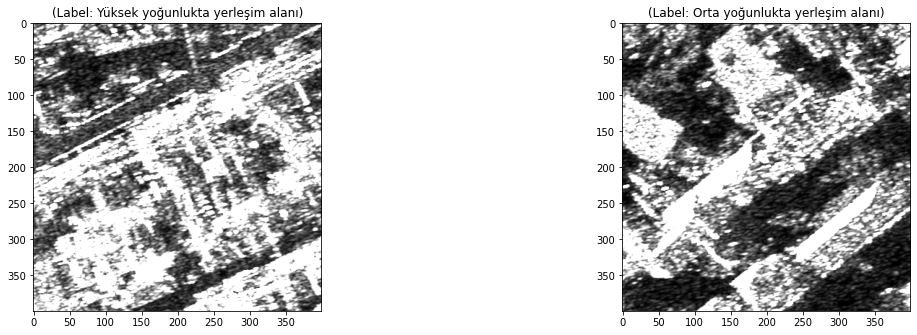

In [ ]:
plt.figure(figsize=[5,5])

plt.subplot(121)
curr_img = np.reshape(G1_full[399], (400,400))
curr_lbl = G1label1[399]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplot(122)
curr_img = np.reshape(X_test[98], (400,400))
curr_lbl = y_test1[98]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplots_adjust(left=0, right=3, bottom=0.1, top=0.9)
plt.savefig('Display.png',bbox_inches= 'tight')

In [ ]:
inChannel = 1
x, y = 400, 400
input_img = Input(shape = (x, y, inChannel))
num_classes = 6

def encoder(input_img):
    #encoder
   
    conv1 = Conv2D(4, (17, 17), activation='relu', padding='valid')(input_img) # kernel size 17x17 olarak değiştirdim ve padding valid yaptım.
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) 
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool4) 
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool6) 
    conv7 = BatchNormalization()(conv7)
    pool7 = MaxPooling2D(pool_size=(2, 2))(conv7)
    conv8 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool7)
    conv8 = BatchNormalization()(conv8)
    return conv8

def decoder(conv8):    
    #decoder

    conv9 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv8) 
    conv9 = BatchNormalization()(conv9)
    up1 = UpSampling2D((2,2))(conv9) 
    conv12 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    conv12 = BatchNormalization()(conv12)
    up2 = UpSampling2D((2,2))(conv12) 
    conv13 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    conv13 = BatchNormalization()(conv13)
    up3 = UpSampling2D((2,2))(conv13) 
    conv14 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv14 = BatchNormalization()(conv14)
    up4 = UpSampling2D((2,2))(conv14) 
    conv15 = Conv2D(32, (3, 3), activation='relu', padding='same')(up4)
    conv15 = BatchNormalization()(conv15)
    up5 = UpSampling2D((2,2))(conv15) 
    conv16 = Conv2D(16, (3, 3), activation='relu', padding='same')(up5)
    conv16 = BatchNormalization()(conv16)
    up6 = UpSampling2D((2,2))(conv16) 
    conv17 = Conv2D(8, (3, 3), activation='relu', padding='same')(up6) 
    conv17 = BatchNormalization()(conv17)
    up7 = UpSampling2D((2,2))(conv17) 
    conv18 = Conv2D(4, (3, 3), activation='relu', padding='same')(up7) 
    conv18 = BatchNormalization()(conv18)
    conv19 = Lambda(lambda x: tf.pad(x, [[0,0], [8,8], [8,8], [0,0]], 'REFLECT'))(conv18)
    decoded = Conv2D(1, (3,3), activation='relu', padding='same')(conv19)
    return decoded


autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 384, 384, 4)       1160      
_________________________________________________________________
batch_normalization (BatchNo (None, 384, 384, 4)       16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 192, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 8)       296       
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 192, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 8)        

In [ ]:
epochs_ = 120
batch = 8

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train1), y_train1)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
print(class_weight_dict)
print(class_weights)
class_weights = class_weights.reshape(1,6)
print(class_weights)

{0: 0.40268456375838924, 1: 4.363636363636363, 2: 2.0869565217391304, 3: 0.9917355371900827, 4: 0.7058823529411765, 5: 2.608695652173913}
[0.40268456 4.36363636 2.08695652 0.99173554 0.70588235 2.60869565]
[[0.40268456 4.36363636 2.08695652 0.99173554 0.70588235 2.60869565]]


In [ ]:
autoencoder_train = autoencoder.fit(X_train, X_train,
                              epochs=epochs_,
                              batch_size=batch,
                              validation_data=(X_val,X_val))

Epoch 1/120
180/180 [==============================] - 9s 48ms/step - loss: 0.0921 - accuracy: 0.0939 - val_loss: 0.1290 - val_accuracy: 5.5348e-04
Epoch 2/120
180/180 [==============================] - 8s 46ms/step - loss: 0.0674 - accuracy: 0.1058 - val_loss: 0.0881 - val_accuracy: 0.0518
Epoch 3/120
180/180 [==============================] - 8s 45ms/step - loss: 0.0624 - accuracy: 0.1085 - val_loss: 0.0628 - val_accuracy: 0.1242
Epoch 4/120
180/180 [==============================] - 8s 45ms/step - loss: 0.0577 - accuracy: 0.1105 - val_loss: 0.0601 - val_accuracy: 0.1200
Epoch 5/120
180/180 [==============================] - 8s 45ms/step - loss: 0.0560 - accuracy: 0.1104 - val_loss: 0.0577 - val_accuracy: 0.1236
Epoch 6/120
180/180 [==============================] - 8s 45ms/step - loss: 0.0549 - accuracy: 0.1109 - val_loss: 0.0557 - val_accuracy: 0.1242
Epoch 7/120
180/180 [==============================] - 8s 45ms/step - loss: 0.0525 - accuracy: 0.1121 - val_loss: 0.0537 - val_accur

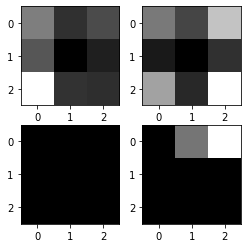

In [ ]:
# 3x3 katmandan görüntülerin gösterimi

model = Model(input_img, encoder(input_img))

from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[359].reshape(1,400,400,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2,col_size*2))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
    plt.savefig('/content/Results/Features_of_autoencoder.png',bbox_inches= 'tight')
display_activation(activations, 2, 2, 21)



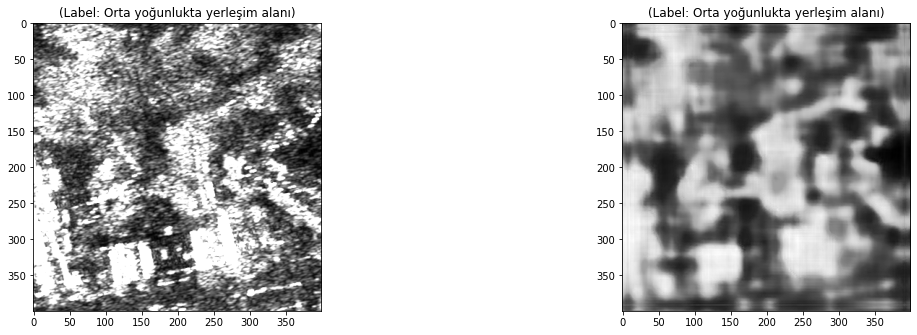

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[359], (1,400,400,1))
curr_lbl = y_train1[359]
plt.imshow(curr_img.reshape(400,400), cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
a = autoencoder.predict(X_train[359].reshape(1,400,400,1))
b =  np.reshape(a,(400,400))
# curr_img = np.reshape(X_test[98], (400,400))
curr_lbl = y_train1[359]
plt.imshow(b, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplots_adjust(left=0, right=3, bottom=0.1, top=0.9)
plt.savefig('/content/Results/Display1223.png',bbox_inches= 'tight')

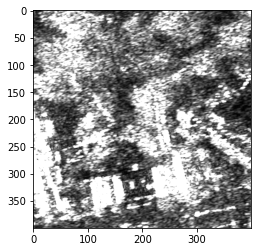

In [ ]:
c= X_train[359].reshape(1,400,400,1)
plt.imshow(c.reshape(400,400), cmap='gray')

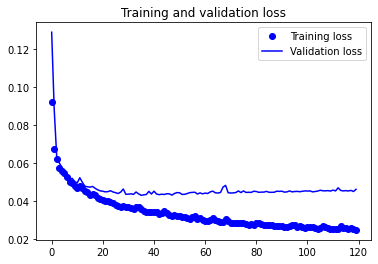

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs_)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('/content/Results/Conv_autoencoder.png')
plt.show()
autoencoder.save_weights('/content/Results/autoencoder.h5')


In [ ]:
def encoder(input_img):
    #encoder
    conv1 = Conv2D(4, (17, 17), activation='relu', padding='valid')(input_img) # kernel size 17x17 olarak değiştirdim ve padding valid yaptım.
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #14 x 14 x 32
    conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool2) #14 x 14 x 64
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) #7 x 7 x 64
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool4) #7 x 7 x 128 (small and thick)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool6) #7 x 7 x 256 (small and thick)
    conv7 = BatchNormalization()(conv7)
    pool7 = MaxPooling2D(pool_size=(2, 2))(conv7)
    conv8 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool7)
    conv8 = BatchNormalization()(conv8)
    return conv8

def fc(enco):
    flat = Flatten()(enco)
    drop1 = Dropout(0.8)(flat)
    den = Dense(128, activation='relu')(drop1) 
    return den

def with_softmax(den):
    drop2 = Dropout(0.7)(den)
    out = Dense(num_classes, activation='softmax')(drop2)
    return out

def with_svm(den):
    drop3 = Dropout(0.6)(den)
    out1 = Dense(num_classes, activation='relu')(drop3)
    return out1
  
encode = encoder(input_img)
output = fc(encode)

full_model = Model(input_img,with_softmax(output))

for l1,l2 in zip(full_model.layers[:24],autoencoder.layers[0:24]):
    l1.set_weights(l2.get_weights())

svm_cae_model = Model(input_img,with_svm(output))

full_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 1)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 384, 384, 4)       1160      
_________________________________________________________________
batch_normalization_24 (Batc (None, 384, 384, 4)       16        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 192, 192, 4)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 192, 192, 8)       296       
_________________________________________________________________
batch_normalization_25 (Batc (None, 192, 192, 8)       32        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 96, 96, 8)        

In [ ]:
epochs_ = 50

In [ ]:
autoencoder.get_weights()[0][1]

array([[[ 0.03591238,  0.03132489,  0.04813756,  0.06611224]],

       [[-0.00962647,  0.04730428, -0.01380818, -0.06462735]],

       [[-0.01944884, -0.02263443, -0.02401735, -0.04681376]],

       [[-0.04769387,  0.03502781,  0.02783535,  0.02967154]],

       [[-0.05312543,  0.03812309, -0.04926322,  0.04035581]],

       [[-0.03549816,  0.04026762,  0.01796249, -0.03244842]],

       [[ 0.04415707,  0.05134042,  0.05165315,  0.02488724]],

       [[ 0.00441966,  0.01761503,  0.05378625, -0.05922214]],

       [[-0.06251363,  0.00373089,  0.06644723,  0.00842248]],

       [[ 0.00625141, -0.06073431,  0.02605303,  0.01576257]],

       [[-0.00966139, -0.0359908 , -0.05503283,  0.03433239]],

       [[-0.05166509,  0.02892765,  0.04332731, -0.0056056 ]],

       [[ 0.04324859,  0.05243194, -0.06725329, -0.00111047]],

       [[-0.01274562,  0.02227268, -0.04072146,  0.01197787]],

       [[-0.00173006,  0.00113265,  0.05979127,  0.02269989]],

       [[-0.03591887, -0.05313021,  0.00

In [ ]:
full_model.get_weights()[0][1]

array([[[ 0.03591238,  0.03132489,  0.04813756,  0.06611224]],

       [[-0.00962647,  0.04730428, -0.01380818, -0.06462735]],

       [[-0.01944884, -0.02263443, -0.02401735, -0.04681376]],

       [[-0.04769387,  0.03502781,  0.02783535,  0.02967154]],

       [[-0.05312543,  0.03812309, -0.04926322,  0.04035581]],

       [[-0.03549816,  0.04026762,  0.01796249, -0.03244842]],

       [[ 0.04415707,  0.05134042,  0.05165315,  0.02488724]],

       [[ 0.00441966,  0.01761503,  0.05378625, -0.05922214]],

       [[-0.06251363,  0.00373089,  0.06644723,  0.00842248]],

       [[ 0.00625141, -0.06073431,  0.02605303,  0.01576257]],

       [[-0.00966139, -0.0359908 , -0.05503283,  0.03433239]],

       [[-0.05166509,  0.02892765,  0.04332731, -0.0056056 ]],

       [[ 0.04324859,  0.05243194, -0.06725329, -0.00111047]],

       [[-0.01274562,  0.02227268, -0.04072146,  0.01197787]],

       [[-0.00173006,  0.00113265,  0.05979127,  0.02269989]],

       [[-0.03591887, -0.05313021,  0.00

In [ ]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
def alternative_weighted_categorical_crossentropy(weights):
    # weights = [0.9,0.05,0.04,0.01]
    def wcce(y_true, y_pred):
        Kweights = K.variable(weights)
        if not K.is_tensor(y_pred): y_pred = K.constant(y_pred)
        y_true = K.cast(y_true, y_pred.dtype)
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
    return wcce

In [ ]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [ ]:
from sklearn.utils import class_weight
class_weighta = class_weight.compute_class_weight('balanced', np.unique(y_train1), y_train1)

In [ ]:
print(class_weighta)
print(class_weight_dict)
class_weight_sozluk = {
    0: 1,
    1: 9,
    2: 4,
    3: 2,
    4: 1,
    5: 6
}

[0.40268456 4.36363636 2.08695652 0.99173554 0.70588235 2.60869565]
{0: 0.40268456375838924, 1: 4.363636363636363, 2: 2.0869565217391304, 3: 0.9917355371900827, 4: 0.7058823529411765, 5: 2.608695652173913}


In [ ]:
for layer in full_model.layers[0:24]:
    layer.trainable = False


full_model.compile(loss=categorical_focal_loss(gamma=2.0, alpha=0.25), optimizer=keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])

In [ ]:
full_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 1)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 384, 384, 4)       1160      
_________________________________________________________________
batch_normalization_24 (Batc (None, 384, 384, 4)       16        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 192, 192, 4)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 192, 192, 8)       296       
_________________________________________________________________
batch_normalization_25 (Batc (None, 192, 192, 8)       32        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 96, 96, 8)        

In [ ]:
classify_train = full_model.fit(X_train, y_train, batch_size = batch, epochs = epochs_ , verbose=1,validation_data=(X_val, y_val))

Epoch 1/50
180/180 [==============================] - 2s 10ms/step - loss: 1.1961 - accuracy: 0.3917 - val_loss: 0.1930 - val_accuracy: 0.6750
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.7196 - accuracy: 0.5333 - val_loss: 0.2055 - val_accuracy: 0.6875
Epoch 3/50
180/180 [==============================] - 2s 9ms/step - loss: 0.6196 - accuracy: 0.5819 - val_loss: 0.1845 - val_accuracy: 0.6875
Epoch 4/50
180/180 [==============================] - 2s 9ms/step - loss: 0.5653 - accuracy: 0.5785 - val_loss: 0.1468 - val_accuracy: 0.7063
Epoch 5/50
180/180 [==============================] - 2s 9ms/step - loss: 0.4693 - accuracy: 0.6069 - val_loss: 0.1235 - val_accuracy: 0.7125
Epoch 6/50
180/180 [==============================] - 2s 9ms/step - loss: 0.4510 - accuracy: 0.5924 - val_loss: 0.1176 - val_accuracy: 0.7188
Epoch 7/50
180/180 [==============================] - 2s 9ms/step - loss: 0.3800 - accuracy: 0.6139 - val_loss: 0.1001 - val_accuracy: 0.7063
Epoch

In [ ]:
full_model.save_weights('/content/Results/autoencoder_classification.h5')

In [ ]:
for layer in full_model.layers[0:24]:
    layer.trainable = True

full_model.compile(loss=categorical_focal_loss(gamma=2.0, alpha=0.25), optimizer=keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])

In [ ]:
classify_train = full_model.fit(X_train, y_train, batch_size=batch,epochs=epochs_  ,verbose=1,validation_data=(X_val, y_val))

Epoch 1/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1042 - accuracy: 0.7160 - val_loss: 0.0890 - val_accuracy: 0.7250
Epoch 2/50
180/180 [==============================] - 4s 22ms/step - loss: 0.1101 - accuracy: 0.6944 - val_loss: 0.0828 - val_accuracy: 0.7437
Epoch 3/50
180/180 [==============================] - 4s 22ms/step - loss: 0.0937 - accuracy: 0.7181 - val_loss: 0.0624 - val_accuracy: 0.7875
Epoch 4/50
180/180 [==============================] - 4s 22ms/step - loss: 0.0850 - accuracy: 0.7396 - val_loss: 0.0546 - val_accuracy: 0.8062
Epoch 5/50
180/180 [==============================] - 4s 22ms/step - loss: 0.0985 - accuracy: 0.7396 - val_loss: 0.0606 - val_accuracy: 0.7625
Epoch 6/50
180/180 [==============================] - 4s 22ms/step - loss: 0.0872 - accuracy: 0.7514 - val_loss: 0.0664 - val_accuracy: 0.8000
Epoch 7/50
180/180 [==============================] - 4s 21ms/step - loss: 0.0876 - accuracy: 0.7375 - val_loss: 0.0763 - val_accuracy: 0.7063

In [ ]:
full_model.save_weights('/content/Results/classification_complete.h5')

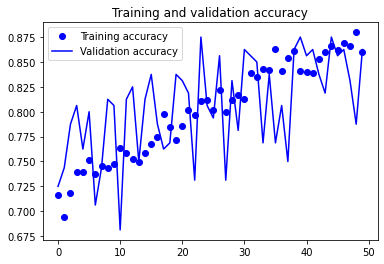

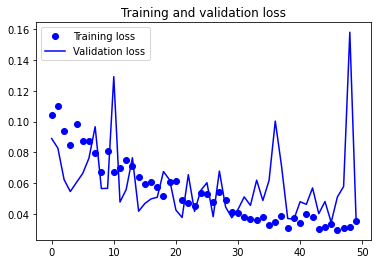

In [ ]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('/content/Results/Training and validation accuracy.png')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('/content/Results/Training and validation loss.png')
plt.show()

In [ ]:
predicted_classes = full_model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test1.shape

((400,), (400,))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test1, predicted_classes, target_names=target_names))
 
acc = accuracy_score(y_test1, predicted_classes)
print("\nAccurancy overall = {}\n".format(acc))

kappa = cohen_kappa_score(y_test1, predicted_classes)
print("Kappa Score = {}\n".format(kappa))

              precision    recall  f1-score   support

     Class 0       0.83      0.99      0.90       166
     Class 1       0.38      0.40      0.39        15
     Class 2       0.62      0.16      0.25        32
     Class 3       0.70      0.76      0.73        67
     Class 4       0.76      0.71      0.74        94
     Class 5       1.00      0.69      0.82        26

    accuracy                           0.78       400
   macro avg       0.72      0.62      0.64       400
weighted avg       0.77      0.78      0.76       400


Accurancy overall = 0.7775

Kappa Score = 0.6854317802263831



In [ ]:
!zip -r /content/Results.zip /content/Results/

from google.colab import files
files.download("/content/Results.zip")

updating: content/Results/ (stored 0%)
updating: content/Results/Display1223.png (deflated 5%)
updating: content/Results/Features_of_autoencoder.png (deflated 15%)
updating: content/Results/autoencoder_classification.h5 (deflated 8%)
updating: content/Results/autoencoder.h5 (deflated 8%)
updating: content/Results/classification_complete.h5 (deflated 8%)
updating: content/Results/Conv_autoencoder.png (deflated 7%)
updating: content/Results/Training and validation loss.png (deflated 6%)
updating: content/Results/Training and validation accuracy.png (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
svm_cae_model = Model(input_img, encode)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf') 
encoded_data = svm_cae_model.predict(X_train, batch_size=batch)
encoded_data = encoded_data.reshape(1440,512*3*3)
clf.fit(encoded_data, y_train1)





SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
X_test_data = svm_cae_model.predict(X_test, batch_size=batch)

In [ ]:
X_test_data = X_test_data.reshape(400,512*9)

In [ ]:
predicted_classes = clf.predict(X_test_data)
# predicted_classes_1 = np.argmax(np.round(predicted_classes))
# predicted_classes_1.shape

In [ ]:
correct = np.where(predicted_classes==y_test1)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[40:65]):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[correct].reshape(400,400), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test1[correct]))
    plt.savefig('correct {}'.format(i))
    plt.tight_layout()
    plt.figure(figsize=(10,10))
    

In [ ]:
incorrect = np.where(predicted_classes!=y_test1)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[incorrect].reshape(400,400), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test1[incorrect]))
    plt.savefig('incorrect {}'.format(i))
    plt.tight_layout()
    plt.figure(figsize=(10,10))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test1, predicted_classes, target_names=target_names))
 
acc = accuracy_score(y_test1, predicted_classes)
print("\nAccurancy overall = {}\n".format(acc))

kappa = cohen_kappa_score(y_test1, predicted_classes)
print("Kappa Score = {}\n".format(kappa))

              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97       166
     Class 1       0.38      0.40      0.39        15
     Class 2       0.52      0.41      0.46        32
     Class 3       0.73      0.64      0.68        67
     Class 4       0.67      0.82      0.74        94
     Class 5       1.00      0.81      0.89        26

    accuracy                           0.80       400
   macro avg       0.71      0.67      0.69       400
weighted avg       0.80      0.80      0.80       400


Accurancy overall = 0.8

Kappa Score = 0.7251496645967

